## Design and Theorical Approach

(1) $k_{i}^{*} = arg$ $min_{j}||x_i-\mu_j|| = arg$ $min_j \sqrt{(x_i-\mu_j)^{T}(x_i-\mu_j)} = arg$ $min_j \sqrt{x_{i}^{T}x_i-x_{i}^{T}\mu_j-\mu_j^{T}x_i+\mu_j^{T}\mu_j} = arg$ $min_j \sqrt{||x_i||^{2}-2<\mu_j,x_i>+||\mu_j||^{2}}$ <br>(since $||x_i||$ and $\mu_j$ all equal to 1) $= arg$ $min_j \sqrt{2-2<\mu_j,x_i>} = arg$ $max_j <\mu_j,x_i>$. <br>
To learn the matrices A & B, we first initalize $\mu_1$ to $\mu_k$. Then, we normalize all $\mu$ and x with L2 norm. Then we create input matrices X whose rows are $x_i$. Let A $\in\mathbb{R}^{dxk}$ be a matrix whose columns are $\mu_j$. Let B $\in\mathbb{R}^{kxd}$ be a matrix whose rows are $\mu_j$.<br> Let C(.) only applies to rows of matrices. $C(x) = [\delta[1-i],\delta[2-i],...,\delta[n-i]], where$ $i = argmax_{i}x_i$ and $x = [x_1,x_2,...,x_n]$. Then, 
$$C(XA) = C(\begin{bmatrix} <\mu_1,x1> & <\mu_2,x1> & \dots & <\mu_k,x1> \\ <\mu_1,x2> & <\mu_2,x2> & \dots & <\mu_k,x2> \\ \vdots & \vdots & \ddots & \vdots \\ <\mu_1,xn> & <\mu_2,xn> & \dots & <\mu_k,xn> \end{bmatrix})$$ $$= \begin{bmatrix} C(<\mu_1,x1> & <\mu_2,x1> & \dots & <\mu_k,x1>) \\ C(<\mu_1,x2> & <\mu_2,x2> & \dots & <\mu_k,x2>) \\ C(\vdots & \vdots & \ddots & \vdots) \\ C(<\mu_1,xn> & <\mu_2,xn> & \dots & <\mu_k,xn>) \end{bmatrix} $$ According to the above derivation, $k_{i}^{*} = arg$ $min_{j} ||\mu_j - x_i||$ = arg $max_{j}<x_i,\mu_j>$, thus,   $$= \begin{bmatrix} \delta[1-k_{1}^{*}] & \delta[2-k_{1}^{*}] & \dots & \delta[k-k_{1}^{*}] \\ \delta[1-k_{2}^{*}] & \delta[2-k_{2}^{*}] & \dots & \delta[k-k_{2}^{*}] \\ \vdots & \vdots & \ddots & \vdots \\ \delta[1-k_{n}^{*}] & \delta[2-k_{n}^{*}] & \dots & \delta[k-k_{n}^{*}] \end{bmatrix}$$ Let matrix D be the summation of rows of C(XA), then i-th numbers of D is the number of $x_i$ belongs to $\mu_i$. And the i-th column of $X^{T}C(XA)$ is sum of all $x_i$ belongs to $\mu_i$. Thus, to update A (new $\mu_i$), we let $\mu_i$ be i-column of $X^{T}C(XA)$ divided i-number of D. Thus, vectorized version of $\mu_j = \frac{1}{|D_j|}\sum_{i|x_i\in D_j}x_i$ can be written as $(X^{T}C(XA))/D$.

### Learning Diagram

<img src="img/1.jpg" width="600">

(2) To use learned matrices A and B, where $B=A^{T}$, follow the below steps: (Let X be a matrix whose rows are $x_i$) <br>
1. Normalize rows of $X$.
2. Encode $X$ by computing $C(XA)$, where $X\in\mathbb{R}^{nxd}$.
3. Transmit C(XA) to decoder, and decode it by computing C(XA)B. 

### Vector Quantization 

<img src="img/2.jpg" width="600">

## Implementation

In [99]:
import numpy as np
import tensorflow as tf
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img

#important variables
n = 1000 #sample size
k = 10 #number of class

mnist = tf.keras.datasets.mnist
(x, y),(x_test, y_test) = mnist.load_data()
x = x.reshape(x.shape[0],x.shape[1]**2)
#intalize A & B and X
Data = np.hstack((x,y.reshape(x.shape[0],1)))
np.random.shuffle(Data)
X = Data[:n,:x.shape[1]].astype(float)
Y_train = Data[:n,x.shape[1]]
A = np.zeros((x.shape[1],k))
for i in range(k):
    for j in range(n):
        if Data[j,x.shape[1]] == i:
            A[:,i] = Data[j,:x.shape[1]]
B = A.T
#normalize X, A, and B
X = X/(LA.norm(X,axis=1).reshape(X.shape[0],1))
A = A/(LA.norm(A,axis=0).reshape(1,k))
B = A.T
A_ori = A.copy()

#set number to iteration to 0
itr = 0

while(True):
    #apply C(.) to rows of XA; Matrix C=C(XA)
    C = np.zeros((n,k))
    C[np.arange(C.shape[0]),np.argmax(X.dot(A),axis=1)[np.arange(C.shape[0])]] = 1
    #compute D
    D = np.sum(C,axis=0).reshape(1,k)
    #compute new mu
    A_new = X.T.dot(C)/D
    #normalize A_new
    A_new = A_new/(LA.norm(A_new,axis=0).reshape(1,k))
    #if not equal, update A and B
    if(np.sum(np.absolute((A_new - A)))!=0):
        A = A_new
        B = A.T
        itr = itr + 1
    else:
        break
print('Iteration: '+str(itr))

Iteration: 22


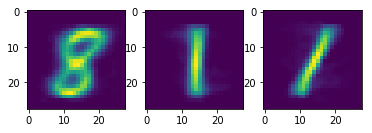

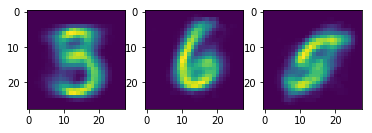

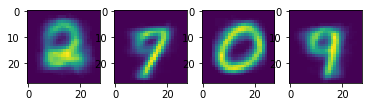

In [100]:
#visual 
for i in range(2):
    figure, axes = plt.subplots(1,3)
    axes[0].imshow(A[:,i*3+0].reshape(28,28))
    axes[1].imshow(A[:,i*3+1].reshape(28,28))
    axes[2].imshow(A[:,i*3+2].reshape(28,28))
    plt.show()
figure, axes = plt.subplots(1,4)
axes[0].imshow(A[:,2*3+0].reshape(28,28))
axes[1].imshow(A[:,2*3+1].reshape(28,28))
axes[2].imshow(A[:,2*3+2].reshape(28,28))
axes[3].imshow(A[:,2*3+3].reshape(28,28))
plt.show()

In [101]:
#manullay assgin the labels for each mu
labels = [8,1,4,3,6,5,2,7,0,9]
err = np.zeros((k,))
class_p = np.zeros((k,))
class_n = np.zeros((k,))
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1]**2)
X_test = X_test/(LA.norm(X_test,axis=1).reshape(X_test.shape[0],1))
predict = np.argmax(B.dot(X_test.T),axis=0)
for i in range(predict.shape[0]):
    predict[i] = labels[predict[i]]
for i in range(predict.shape[0]):
    class_n[y_test[i]] = class_n[y_test[i]] + 1
    class_p[predict[i]] = class_p[predict[i]] + 1
    if(predict[i] != y_test[i]):
        err[y_test[i]] = err[y_test[i]] + 1
print('Total number of correct labels is '+str(predict.shape[0]-np.sum(err)))
print('Estimated probability of classification error is '+str(np.sum(err)/np.sum(class_n)))
for i in range(k):
    print('Probability of error for number '+str(i)+' is '+str(err[i]/class_n[i]))
print('Average probability of error for all classes is '+str(np.sum(err)/np.sum(class_n)))

Total number of correct labels is 5477.0
Estimated probability of classification error is 0.4523
Probability of error for number 0 is 0.1816326530612245
Probability of error for number 1 is 0.44140969162995597
Probability of error for number 2 is 0.311046511627907
Probability of error for number 3 is 0.24356435643564356
Probability of error for number 4 is 0.984725050916497
Probability of error for number 5 is 0.7410313901345291
Probability of error for number 6 is 0.34029227557411273
Probability of error for number 7 is 0.4727626459143969
Probability of error for number 8 is 0.4240246406570842
Probability of error for number 9 is 0.42021803766105054
Average probability of error for all classes is 0.4523


### Training Diagram

<img src="img/3.jpg" width="600">

### Vector Quantization 

<img src="img/0.jpg" width="600">

In [38]:
#important variables
n = 1000 #sample size
k = 10 #number of class

mnist = tf.keras.datasets.mnist
(x, y),(x_test, y_test) = mnist.load_data()
x = x.reshape(x.shape[0],x.shape[1]**2)
#intalize A & B and X
Data = np.hstack((x,y.reshape(x.shape[0],1)))
np.random.shuffle(Data)
X = Data[:n,:x.shape[1]].astype(float)
A = np.zeros((x.shape[1],k))
for i in range(k):
    for j in range(n):
        if Data[j,x.shape[1]] == i:
            A[:,i] = Data[j,:x.shape[1]]

A_ori = A.copy()
#PCA
X_v = X.T.astype(float)
one = np.ones((n,1))
cov = X_v.dot((np.identity(n) - one.dot(one.T)/n)).dot(X_v.T)/n
# 4. compute the eigenvalues λi and eigenvectors φi of Σ.
lamda, phi = LA.eig(cov)
#5. order the eigenvalues by decreasing value
pos = np.argsort(lamda)
lamda[lamda.shape[0]-1-np.arange(lamda.shape[0])] = lamda[pos]
phi[:,phi.shape[0]-1-np.arange(phi.shape[0])] = phi[:,pos]
#6. create the matrix Φp with the p surviving eigenvectors as columns. 


In [75]:
#used to record average error for all different p values
ERR = [0,0,0,0]

Iterations: 17


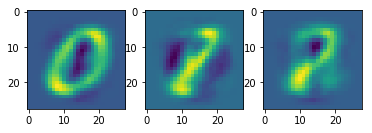

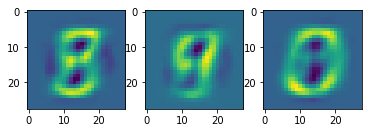

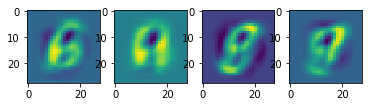

In [76]:
p=6

lamdaP = lamda[:p]
phi_p = phi[:,:p]

#k- means

# Z = np.real(phi_p.T.dot(XC).T)
# A = np.real(phi_p.T.dot(A))
Z = np.real(phi_p.T.dot(X.T).T)
A = np.real(phi_p.T.dot(A_ori))

#normalize
Z = Z/(LA.norm(X,axis=1).reshape(Z.shape[0],1))
A = A/(LA.norm(A,axis=0).reshape(1,k))
B = A.T
#set number to iteration to 0
itr = 0

while(True):
    #apply C(.) to rows of XA; Matrix C=C(XA)
    C = np.zeros((n,k))
    C[np.arange(C.shape[0]),np.argmax(Z.dot(A),axis=1)[np.arange(C.shape[0])]] = 1
    #compute D
    D = np.sum(C,axis=0).reshape(1,k)
    #compute new mu
    A_new = Z.T.dot(C)/D
    #normalize A_new
    A_new = A_new/(LA.norm(A_new,axis=0).reshape(1,k))
    #if not equal, update A and B
    if(np.sum(np.absolute((A_new - A)))!=0):
        A = A_new
        B = A.T
        itr = itr + 1
    else:
        break
print('Iterations: '+str(itr))


#visual 
A_ = np.real(phi_p.dot(A))
for i in range(2):
    figure, axes = plt.subplots(1,3)
    axes[0].imshow(A_[:,i*3+0].reshape(28,28))
    axes[1].imshow(A_[:,i*3+1].reshape(28,28))
    axes[2].imshow(A_[:,i*3+2].reshape(28,28))
    plt.show()
figure, axes = plt.subplots(1,4)
axes[0].imshow(A_[:,2*3+0].reshape(28,28))
axes[1].imshow(A_[:,2*3+1].reshape(28,28))
axes[2].imshow(A_[:,2*3+2].reshape(28,28))
axes[3].imshow(A_[:,2*3+3].reshape(28,28))
plt.show()

In [77]:
#manually assign labels
labels = [0,1,2,3,4,5,6,7,8,9]
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1]**2)
Z = np.real(phi_p.T.dot(X_test.T)).T
Z = Z/(LA.norm(Z,axis=1).reshape(Z.shape[0],1))
predict = np.argmax(B.dot(Z.T),axis=0)
for i in range(predict.shape[0]):
    predict[i] = labels[predict[i]]
err = np.zeros((k,))
class_p = np.zeros((k,))
class_n = np.zeros((k,))
for i in range(predict.shape[0]):
    class_n[y_test[i]] = class_n[y_test[i]] + 1
    class_p[predict[i]] = class_p[predict[i]] + 1
    if(predict[i] != y_test[i]):
        err[y_test[i]] = err[y_test[i]] + 1
print('Total number of correct labels is '+str(predict.shape[0]-np.sum(err)))
print('Estimated probability of classification error is '+str(np.sum(err)/np.sum(class_n)))
for i in range(k):
    print('Probability of error for number '+str(i)+' is '+str(err[i]/class_n[i]))
print('Average probability of error for all classes is '+str(np.sum(err)/np.sum(class_n)))
ERR[0] = np.sum(err)/np.sum(class_n)

Total number of correct labels is 4612.0
Estimated probability of classification error is 0.5388
Probability of error for number 0 is 0.45918367346938777
Probability of error for number 1 is 0.20352422907488987
Probability of error for number 2 is 0.2238372093023256
Probability of error for number 3 is 0.31584158415841584
Probability of error for number 4 is 0.5285132382892057
Probability of error for number 5 is 0.9013452914798207
Probability of error for number 6 is 0.3966597077244259
Probability of error for number 7 is 0.9785992217898832
Probability of error for number 8 is 0.6550308008213552
Probability of error for number 9 is 0.8027750247770069
Average probability of error for all classes is 0.5388


Iterations: 25


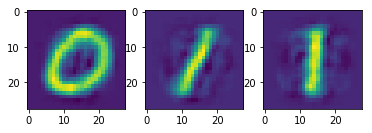

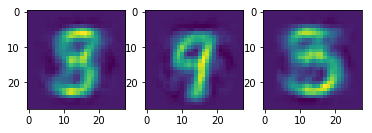

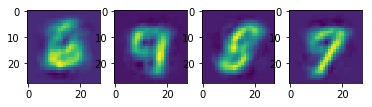

In [78]:
p=25

lamdaP = lamda[:p]
phi_p = phi[:,:p]

#k- means

Z = np.real(phi_p.T.dot(X.T).T)
A = np.real(phi_p.T.dot(A_ori))

#normalize
Z = Z/(LA.norm(X,axis=1).reshape(Z.shape[0],1))
A = A/(LA.norm(A,axis=0).reshape(1,k))
B = A.T
#set number to iteration to 0
itr = 0

while(True):
    #apply C(.) to rows of XA; Matrix C=C(XA)
    C = np.zeros((n,k))
    C[np.arange(C.shape[0]),np.argmax(Z.dot(A),axis=1)[np.arange(C.shape[0])]] = 1
    #compute D
    D = np.sum(C,axis=0).reshape(1,k)
    #compute new mu
    A_new = Z.T.dot(C)/D
    #normalize A_new
    A_new = A_new/(LA.norm(A_new,axis=0).reshape(1,k))
    #if not equal, update A and B
    if(np.sum(np.absolute((A_new - A)))!=0):
        A = A_new
        B = A.T
        itr = itr + 1
    else:
        break
print('Iterations: '+str(itr))


#visual 
A_ = np.real(phi_p.dot(A))
for i in range(2):
    figure, axes = plt.subplots(1,3)
    axes[0].imshow(A_[:,i*3+0].reshape(28,28))
    axes[1].imshow(A_[:,i*3+1].reshape(28,28))
    axes[2].imshow(A_[:,i*3+2].reshape(28,28))
    plt.show()
figure, axes = plt.subplots(1,4)
axes[0].imshow(A_[:,2*3+0].reshape(28,28))
axes[1].imshow(A_[:,2*3+1].reshape(28,28))
axes[2].imshow(A_[:,2*3+2].reshape(28,28))
axes[3].imshow(A_[:,2*3+3].reshape(28,28))
plt.show()

In [79]:
#manually assign labels
labels = [0,4,1,8,9,3,6,2,5,7]
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1]**2)
Z = np.real(phi_p.T.dot(X_test.T)).T
Z = Z/(LA.norm(Z,axis=1).reshape(Z.shape[0],1))
predict = np.argmax(B.dot(Z.T),axis=0)
for i in range(predict.shape[0]):
    predict[i] = labels[predict[i]]
err = np.zeros((k,))
class_p = np.zeros((k,))
class_n = np.zeros((k,))
for i in range(predict.shape[0]):
    class_n[y_test[i]] = class_n[y_test[i]] + 1
    class_p[predict[i]] = class_p[predict[i]] + 1
    if(predict[i] != y_test[i]):
        err[y_test[i]] = err[y_test[i]] + 1
print('Total number of correct labels is '+str(predict.shape[0]-np.sum(err)))
print('Estimated probability of classification error is '+str(np.sum(err)/np.sum(class_n)))
for i in range(k):
    print('Probability of error for number '+str(i)+' is '+str(err[i]/class_n[i]))
print('Average probability of error for all classes is '+str(np.sum(err)/np.sum(class_n)))
ERR[1] = np.sum(err)/np.sum(class_n)

Total number of correct labels is 4470.0
Estimated probability of classification error is 0.553
Probability of error for number 0 is 0.19693877551020408
Probability of error for number 1 is 0.4220264317180617
Probability of error for number 2 is 0.9912790697674418
Probability of error for number 3 is 0.5673267326732673
Probability of error for number 4 is 0.9898167006109979
Probability of error for number 5 is 0.6289237668161435
Probability of error for number 6 is 0.16597077244258873
Probability of error for number 7 is 0.5340466926070039
Probability of error for number 8 is 0.4650924024640657
Probability of error for number 9 is 0.5629335976214074
Average probability of error for all classes is 0.553


Iterations: 23


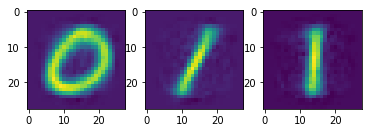

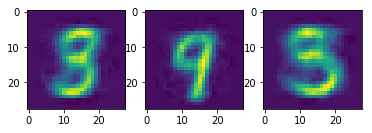

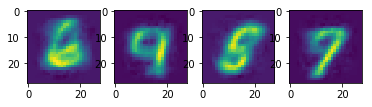

In [80]:
p=86

lamdaP = lamda[:p]
phi_p = phi[:,:p]

#k- means

Z = np.real(phi_p.T.dot(X.T).T)
A = np.real(phi_p.T.dot(A_ori))

#normalize
Z = Z/(LA.norm(X,axis=1).reshape(Z.shape[0],1))
A = A/(LA.norm(A,axis=0).reshape(1,k))
B = A.T
#set number to iteration to 0
itr = 0

while(True):
    #apply C(.) to rows of XA; Matrix C=C(XA)
    C = np.zeros((n,k))
    C[np.arange(C.shape[0]),np.argmax(Z.dot(A),axis=1)[np.arange(C.shape[0])]] = 1
    #compute D
    D = np.sum(C,axis=0).reshape(1,k)
    #compute new mu
    A_new = Z.T.dot(C)/D
    #normalize A_new
    A_new = A_new/(LA.norm(A_new,axis=0).reshape(1,k))
    #if not equal, update A and B
    if(np.sum(np.absolute((A_new - A)))!=0):
        A = A_new
        B = A.T
        itr = itr + 1
    else:
        break
print('Iterations: '+str(itr))


#visual 
A_ = np.real(phi_p.dot(A))
for i in range(2):
    figure, axes = plt.subplots(1,3)
    axes[0].imshow(A_[:,i*3+0].reshape(28,28))
    axes[1].imshow(A_[:,i*3+1].reshape(28,28))
    axes[2].imshow(A_[:,i*3+2].reshape(28,28))
    plt.show()
figure, axes = plt.subplots(1,4)
axes[0].imshow(A_[:,2*3+0].reshape(28,28))
axes[1].imshow(A_[:,2*3+1].reshape(28,28))
axes[2].imshow(A_[:,2*3+2].reshape(28,28))
axes[3].imshow(A_[:,2*3+3].reshape(28,28))
plt.show()

In [81]:
#manually assign labels
labels = labels = [0,4,1,8,9,3,6,2,5,7]
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1]**2)
Z = np.real(phi_p.T.dot(X_test.T)).T
Z = Z/(LA.norm(Z,axis=1).reshape(Z.shape[0],1))
predict = np.argmax(B.dot(Z.T),axis=0)
for i in range(predict.shape[0]):
    predict[i] = labels[predict[i]]
err = np.zeros((k,))
class_p = np.zeros((k,))
class_n = np.zeros((k,))
for i in range(predict.shape[0]):
    class_n[y_test[i]] = class_n[y_test[i]] + 1
    class_p[predict[i]] = class_p[predict[i]] + 1
    if(predict[i] != y_test[i]):
        err[y_test[i]] = err[y_test[i]] + 1
print('Total number of correct labels is '+str(predict.shape[0]-np.sum(err)))
print('Estimated probability of classification error is '+str(np.sum(err)/np.sum(class_n)))
for i in range(k):
    print('Probability of error for number '+str(i)+' is '+str(err[i]/class_n[i]))
print('Average probability of error for all classes is '+str(np.sum(err)/np.sum(class_n)))
ERR[2] = np.sum(err)/np.sum(class_n)

Total number of correct labels is 4416.0
Estimated probability of classification error is 0.5584
Probability of error for number 0 is 0.20204081632653062
Probability of error for number 1 is 0.4220264317180617
Probability of error for number 2 is 0.9922480620155039
Probability of error for number 3 is 0.5693069306930693
Probability of error for number 4 is 0.9887983706720977
Probability of error for number 5 is 0.6143497757847534
Probability of error for number 6 is 0.1617954070981211
Probability of error for number 7 is 0.5437743190661478
Probability of error for number 8 is 0.5225872689938398
Probability of error for number 9 is 0.5609514370664024
Average probability of error for all classes is 0.5584


Iterations: 25


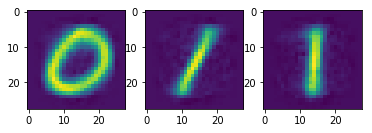

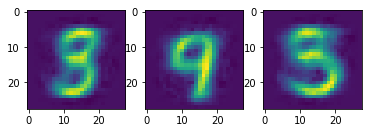

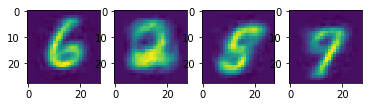

In [82]:
p=100

lamdaP = lamda[:p]
phi_p = phi[:,:p]

#k- means

Z = np.real(phi_p.T.dot(X.T).T)
A = np.real(phi_p.T.dot(A_ori))

#normalize
Z = Z/(LA.norm(X,axis=1).reshape(Z.shape[0],1))
A = A/(LA.norm(A,axis=0).reshape(1,k))
B = A.T
#set number to iteration to 0
itr = 0

while(True):
    #apply C(.) to rows of XA; Matrix C=C(XA)
    C = np.zeros((n,k))
    C[np.arange(C.shape[0]),np.argmax(Z.dot(A),axis=1)[np.arange(C.shape[0])]] = 1
    #compute D
    D = np.sum(C,axis=0).reshape(1,k)
    #compute new mu
    A_new = Z.T.dot(C)/D
    #normalize A_new
    A_new = A_new/(LA.norm(A_new,axis=0).reshape(1,k))
    #if not equal, update A and B
    if(np.sum(np.absolute((A_new - A)))!=0):
        A = A_new
        B = A.T
        itr = itr + 1
    else:
        break
print('Iterations: '+str(itr))


#visual 
A_ = np.real(phi_p.dot(A))
for i in range(2):
    figure, axes = plt.subplots(1,3)
    axes[0].imshow(A_[:,i*3+0].reshape(28,28))
    axes[1].imshow(A_[:,i*3+1].reshape(28,28))
    axes[2].imshow(A_[:,i*3+2].reshape(28,28))
    plt.show()
figure, axes = plt.subplots(1,4)
axes[0].imshow(A_[:,2*3+0].reshape(28,28))
axes[1].imshow(A_[:,2*3+1].reshape(28,28))
axes[2].imshow(A_[:,2*3+2].reshape(28,28))
axes[3].imshow(A_[:,2*3+3].reshape(28,28))
plt.show()

In [83]:
#manually assign labels
labels = [0,4,1,8,9,3,6,2,5,7]
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1]**2)
Z = np.real(phi_p.T.dot(X_test.T)).T
Z = Z/(LA.norm(Z,axis=1).reshape(Z.shape[0],1))
predict = np.argmax(B.dot(Z.T),axis=0)
for i in range(predict.shape[0]):
    predict[i] = labels[predict[i]]
err = np.zeros((k,))
class_p = np.zeros((k,))
class_n = np.zeros((k,))
for i in range(predict.shape[0]):
    class_n[y_test[i]] = class_n[y_test[i]] + 1
    class_p[predict[i]] = class_p[predict[i]] + 1
    if(predict[i] != y_test[i]):
        err[y_test[i]] = err[y_test[i]] + 1
print('Total number of correct labels is '+str(predict.shape[0]-np.sum(err)))
print('Estimated probability of classification error is '+str(np.sum(err)/np.sum(class_n)))
for i in range(k):
    print('Probability of error for number '+str(i)+' is '+str(err[i]/class_n[i]))
print('Average probability of error for all classes is '+str(np.sum(err)/np.sum(class_n)))
ERR[3] = np.sum(err)/np.sum(class_n)

Total number of correct labels is 5319.0
Estimated probability of classification error is 0.4681
Probability of error for number 0 is 0.20510204081632652
Probability of error for number 1 is 0.4211453744493392
Probability of error for number 2 is 0.27228682170542634
Probability of error for number 3 is 0.5762376237623762
Probability of error for number 4 is 0.9898167006109979
Probability of error for number 5 is 0.6031390134529148
Probability of error for number 6 is 0.29227557411273486
Probability of error for number 7 is 0.4581712062256809
Probability of error for number 8 is 0.5010266940451745
Probability of error for number 9 is 0.3865213082259663
Average probability of error for all classes is 0.4681


[0.5388 0.553  0.5584 0.4681]


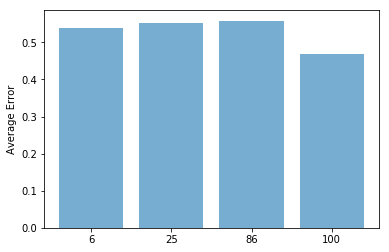

In [97]:
P_val = ('6', '25', '86', '100')
y_pos = np.arange(len(P_val))
ERR = np.asarray(ERR)
plt.bar(y_pos, ERR, align='center', alpha=0.6)
plt.xticks(y_pos, P_val)
plt.ylabel('Average Error')
print(ERR)